In [1]:
import numpy as np
import gym
import random
import time
from random import sample 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers
from keras import layers
from keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def plotGraph(print_reward):
    x = np.arange(len(print_reward))
    y = print_reward

    plt.plot(x, y) 

    plt.xlabel('Episodes') 
    plt.ylabel('Rewards') 
    plt.title('Performance graph!') 

    plt.show()

### Part A - Print out state and action space

In [3]:
env = gym.make('CartPole-v0')
env.reset()
print("Number of actions => ",env.action_space.n)
print('State dimension', env.observation_space.shape)

Number of actions =>  2
State dimension (4,)


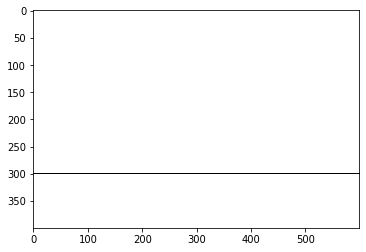

In [4]:
img = plt.imshow(env.render(mode='rgb_array'))
rewardl =[]
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    new_state, reward,done,emt = env.step(action)
    rewardl.append(reward)
env.close()

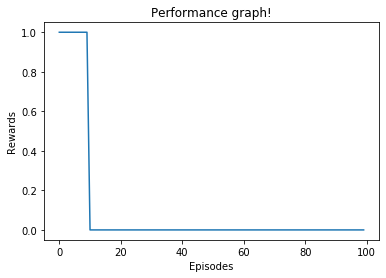

In [5]:
plotGraph(rewardl)

#### Random agent for LunarLander-v2

In [6]:
env = gym.make('LunarLander-v2')
env.reset()
print("Number of actions => ",env.action_space.n)
print('State dimension', env.observation_space.shape)

Number of actions =>  4
State dimension (8,)


/home/gagandeep/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


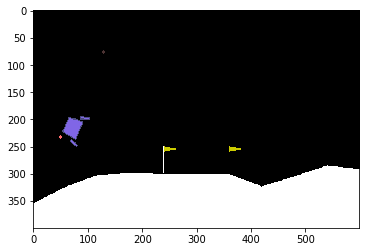

In [7]:
img = plt.imshow(env.render(mode='rgb_array'))
rewardl =[]
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    new_state, reward,done,emt = env.step(action)
    rewardl.append(reward)
env.close()

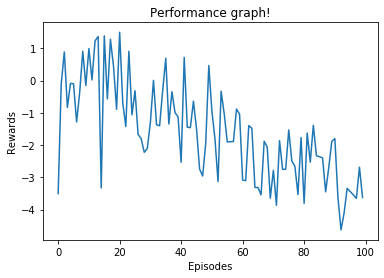

In [8]:
plotGraph(rewardl)

### Part B -

#### Implementation of Policy Gradient algorithm

In [4]:
def PolicyGradient(env_name,count_episode,discount_rate,normalize,reward2go,batchOn):
    env = gym.make(env_name)
    env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    print_reward = []
    
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(output_dim, activation="softmax")
    ])

    #Computing Loss
    p_action = model.output
    a_1hot = K.placeholder(shape=(None, output_dim),name="a1hot")
    dreward = K.placeholder(shape=(None,),name="dreward")

    pSum = K.sum(p_action * a_1hot, axis=1)
    loss = K.mean(- K.log(pSum) * dreward)

    #Updating loss
    adam = optimizers.Adam()
    updates = adam.get_updates(params=model.trainable_weights,loss=loss)
    train_fn = K.function(inputs=[model.input,a_1hot,dreward],outputs=[model.output],updates=updates)
    
    # Run for each episode
    for episode in range(count_episode):
        state = env.reset()
        # Declare list of state, action and reward
        stateList = []
        actionList = []
        rewardList = []
        done = False
        totalReward = 0
        #Flag for batch mode ON/OFF
        if batchOn:
            timestep =0
            for i in range(3):
                done=False
                state = env.reset()
                while not done:
                    timestep+=1
                    #Predict probabilities
                    oPr = model.predict(state[np.newaxis,:])[0]
                    action = np.random.choice(output_dim,p=oPr)
                    new_state, reward,done,emt = env.step(action)
                    #Render env
                    img.set_data(env.render(mode='rgb_array'))
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    #append state action reward information
                    stateList.append(state)
                    actionList.append(action)
                    rewardList.append(reward)
                    totalReward+= reward
                    #update state to new
                    state = new_state
        else:
            timestep = 0
            while not done:
                #Predict probabilities
                timestep+=1
                oPr = model.predict(state[np.newaxis,:])[0]
                action = np.random.choice(output_dim,p=oPr)
                new_state, reward,done,emt = env.step(action)
                #Render env
                img.set_data(env.render(mode='rgb_array'))
                display.display(plt.gcf())
                display.clear_output(wait=True)
                #append state action reward information
                stateList.append(state)
                actionList.append(action)
                rewardList.append(reward)
                totalReward+= reward
                #update state to new
                state = new_state
        stateList = np.array(stateList)
        actionList = np.array(actionList)
        rewardList = np.array(rewardList)
        print_reward.append(totalReward/timestep)
        
        #Do one hot encoding on actionList
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = actionList.reshape(len(actionList), 1)
        actionList = onehot_encoder.fit_transform(integer_encoded)
        print("Episode number ->", episode)
        print("Action shape ->",actionList.shape)
        
        #Generate expected future reward at every timestep
        expected_reward= np.zeros_like(rewardList)
        print("Expected_reward shape ->",expected_reward.shape)
        
        # Flag reward2go ON/OFF
        if reward2go:
            for i in range(len(rewardList)):
                temp = 0
                for j in range(i,len(rewardList)):
                    temp += rewardList[j]*discount_rate
                expected_reward[i]=temp
        else:
            temp =0
            for x in rewardList:
                temp+=x*discount_rate
            expected_reward += temp
        #Flag Advantage normalization ON/OFF
        if normalize:
            if expected_reward.std() > 0:
                standard_deviation = expected_reward.std()
            else:
                standard_deviation = 1    
            expected_reward -= expected_reward.mean() / standard_deviation
        if actionList.shape[1]==4:
            train_fn([stateList,actionList,expected_reward])
    return print_reward

### Running Policy gradient without Normalization and reward2go

Episode number -> 899
Action shape -> (112, 4)
Expected_reward shape -> (112,)


/home/gagandeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


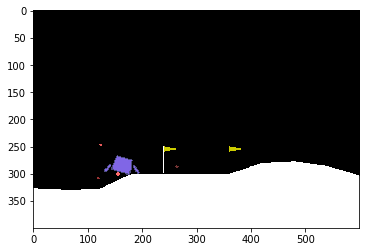

In [9]:
# env_name,count_episode,discount_rate,normalize,reward2go
plotGraph1 = PolicyGradient("LunarLander-v2",900,0.99,False,False,False)

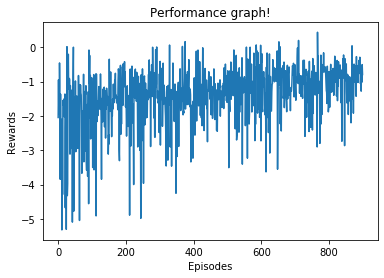

In [10]:
plotGraph(plotGraph1)

### Running Policy gradient with Normalization and without reward2go

Episode number -> 899
Action shape -> (85, 4)
Expected_reward shape -> (85,)


/home/gagandeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


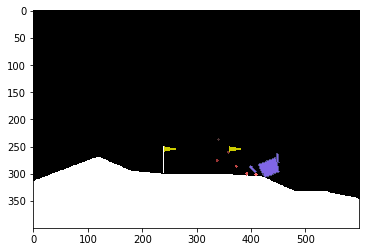

In [11]:
# env_name,count_episode,discount_rate,normalize,reward2go
plotGraph2 = PolicyGradient("LunarLander-v2",900,0.99,True,False,False)

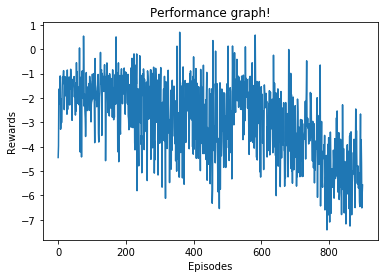

In [12]:
plotGraph(plotGraph2)

### Running Policy gradient without Normalization and with reward2go

Episode number -> 899
Action shape -> (88, 4)
Expected_reward shape -> (88,)


/home/gagandeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


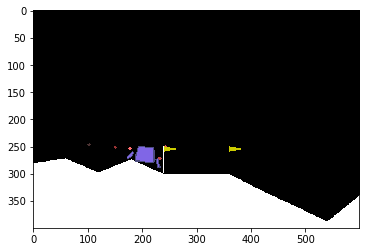

In [13]:
# env_name,count_episode,discount_rate,normalize,reward2go
plotGraph3 = PolicyGradient("LunarLander-v2",600,0.99,False,True,False)

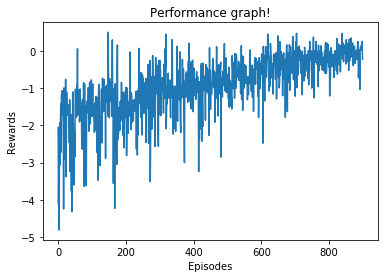

In [14]:
plotGraph(plotGraph3)

### Running Policy gradient with Normalization and reward2go

Episode number -> 899
Action shape -> (123, 4)
Expected_reward shape -> (123,)


/home/gagandeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


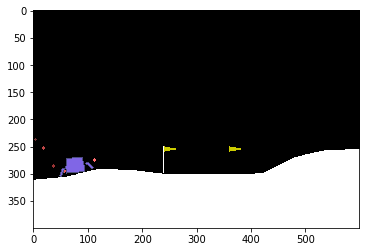

In [15]:
# env_name,count_episode,discount_rate,normalize,reward2go
plotGraph4 = PolicyGradient("LunarLander-v2",600,0.99,True,True,False)

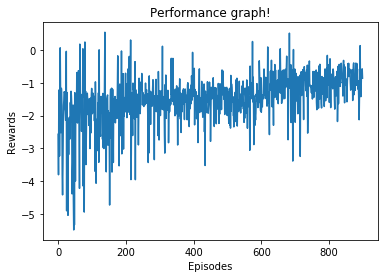

In [16]:
plotGraph(plotGraph4)

### Part C - Policy gradient with batch

### Running Policy gradient without Normalization and reward2go

Episode number -> 149
Action shape -> (229, 4)
Expected_reward shape -> (229,)


/home/gagandeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


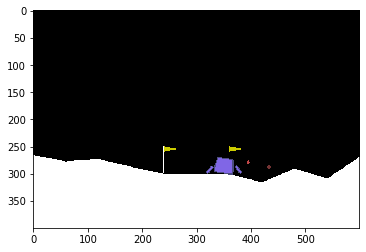

In [5]:
# env_name,count_episode,discount_rate,normalize,reward2go
plotGraph_batch1 = PolicyGradient("LunarLander-v2",150,0.99,False,False,True)

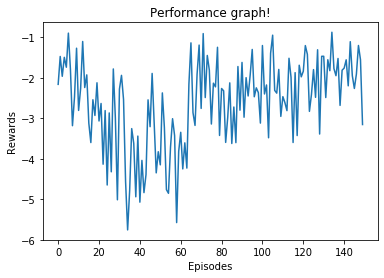

In [6]:
plotGraph(plotGraph_batch1)

### Running Policy gradient with Normalization and without reward2go

Episode number -> 149
Action shape -> (274, 4)
Expected_reward shape -> (274,)


/home/gagandeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


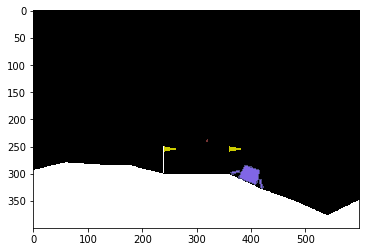

In [5]:
# env_name,count_episode,discount_rate,normalize,reward2go
plotGraph_batch2 = PolicyGradient("LunarLander-v2",150,0.99,True,False,True)

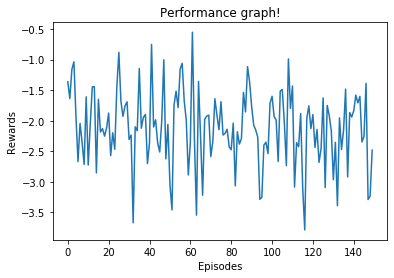

In [6]:
plotGraph(plotGraph_batch2)

### Running Policy gradient without Normalization and with reward2go

Episode number -> 149
Action shape -> (225, 4)
Expected_reward shape -> (225,)


/home/gagandeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


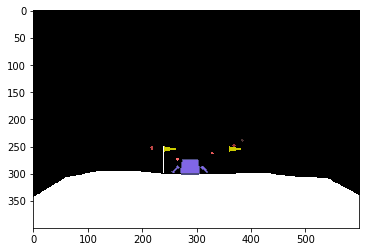

In [7]:
# env_name,count_episode,discount_rate,normalize,reward2go
plotGraph_batch3 = PolicyGradient("LunarLander-v2",150,0.99,False,True,True)

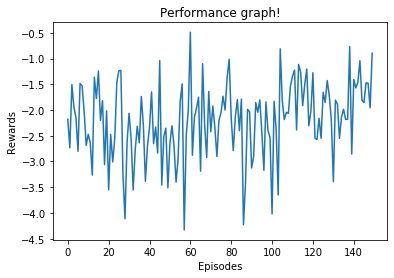

In [8]:
plotGraph(plotGraph_batch3)

### Running Policy gradient with Normalization and reward2go

Episode number -> 199
Action shape -> (291, 4)
Expected_reward shape -> (291,)


/home/gagandeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


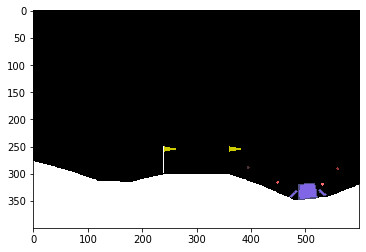

In [5]:
# env_name,count_episode,discount_rate,normalize,reward2go
plotGraph_batch4 = PolicyGradient("LunarLander-v2",200,0.99,True,True,True)

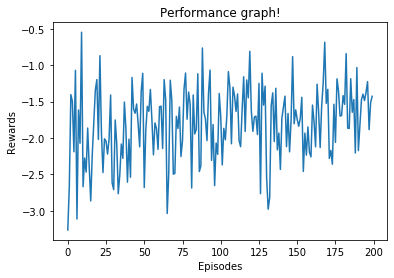

In [6]:
plotGraph(plotGraph_batch4)